In [2]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import community
from collections import Counter

def parseDataset(path):
    df = pd.read_table(path, delimiter='\t', names=['source','target'])
    return nx.from_pandas_edgelist(df,"source","target")

def parseJson(path):
    with open(path) as f:
        data = json.load(f)
        return nx.node_link_graph(data, directed=False)

ridotto = True
con_foci = True


In [3]:
#Graph creation
dataset_path= "reducer/all_datas.json"
#G = parseDataset(dataset_path)
G= parseJson(dataset_path)

In [4]:
#generic analysis
print(G)


Graph with 24568 nodes and 19898 edges


In [21]:
#distances analysis QUESTA MISURA VA FATTA SUL GRAFO RIDOTTO
if ridotto:
    distances_sum = 0
    average_path_lcc = 0
    all_p = []
    connected_components= list(sorted(nx.connected_components(G), key=len, reverse=True))
    examined_components = 0
    for C in (G.subgraph(c).copy() for c in connected_components):
        p = dict(nx.shortest_path_length(C)) #questo conterrà tutte le distanze, per poter guardare max, min e media
        all_p.append(p)
        distance = nx.average_shortest_path_length(C)
        distances_sum += distance
        if distance != 0:
            examined_components += 1
        if average_path_lcc == 0:
            average_path_lcc = distance

    print("Average distance: ", distances_sum/examined_components)
    print("Average lcc path: ", average_path_lcc)


Average distance:  1.1026938012428609


In [22]:
#clustering coefficient
print("Clustering coefficient: "+str(nx.average_clustering(G)))


Clustering coefficient: 0.07238913055844667


Il grafo è connesso? False
Componenti connesse: 18082
largest connected component size: 5538


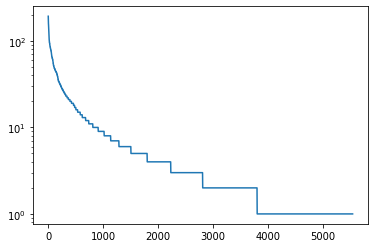

In [24]:
#largest connected component
print("Il grafo è connesso? "+str(nx.is_connected(G)))
print("Componenti connesse: "+ str(nx.number_connected_components(G)))
core_nodes = max(nx.connected_components(G), key=len)
print(f"largest connected component size: {len(core_nodes)}")
core = G.subgraph(core_nodes)

#analizzo i degree all'interno della sola largest connected components per scoprire se la sua dimensione è dovuta a molti nodi che si incontrano oppure a supernodi Hub
largest_component = G.subgraph(core_nodes).copy()
core_degree_sequence = sorted([d for n, d in largest_component.degree()], reverse=True)  # degree sequence
plt.yscale('log')
plt.plot(core_degree_sequence)
#nx.draw(core, with_labels=True)

average degree: 1.6198306740475414
17443
degree sequence: [193, 178, 172, 166, 157, 155, 149, 141, 138, 133, 132, 117, 109, 109, 109, 107, 106, 104, 101, 99, 97, 97, 97, 95, 94, 94, 93, 93, 92, 90, 88, 88, 86, 86, 86, 85, 84, 84, 84, 83, 83, 82, 82, 80, 80, 79, 79, 79, 78, 78, 77, 77, 77, 76, 76, 74, 74, 73, 72, 69, 69, 68, 68, 67, 67, 66, 66, 65, 65, 64, 64, 64, 63, 63, 63, 63, 62, 61, 61, 61, 61, 61, 61, 60, 60, 58, 58, 58, 57, 56, 55, 55, 54, 54, 53, 53, 52, 52, 52, 51, 51, 51, 51, 51, 50, 50, 50, 49, 49, 49, 48, 48, 48, 48, 48, 48, 48, 48, 48, 47, 47, 47, 47, 46, 46, 46, 46, 46, 45, 45, 45, 45, 45, 45, 45, 45, 45, 44, 44, 44, 44, 44, 44, 44, 44, 43, 43, 43, 43, 43, 43, 43, 43, 42, 42, 42, 42, 41, 41, 41, 41, 41, 40, 40, 40, 40, 39, 39, 39, 39, 39, 38, 38, 38, 38, 37, 36, 36, 36, 36, 36, 35, 35, 35, 35, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 33, 33, 33, 33, 33, 33, 33, 33, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 30, 30, 30, 30, 30

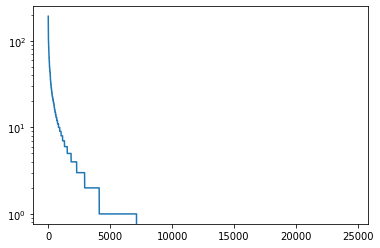

In [61]:
#degree analysis QUESTA MISURA VA FATTA SUL GRAFO COMPLETO
if not ridotto:
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
    plt.yscale('log')
    plt.plot(degree_sequence)

    print("average degree: " + str(sum(degree_sequence)/len(degree_sequence)))
    #wtf? average degree 7?
    print(degree_sequence.count(min(degree_sequence)))
    #ah, ecco perchè.

    print("degree sequence: " + str(degree_sequence))

In [ ]:
#Degree correlation
print("Degree correlation: "+str(nx.degree_pearson_correlation_coefficient(G)))
print("Degree correlation: "+str(nx.degree_pearson_correlation_coefficient(largest_component)))

In [ ]:
#community detection
#communities = community_louvain.best_partition(G)
largest_component_communities = community.community_louvain.best_partition(largest_component)
# number of communities
#print(Counter(communities.values()))
print(Counter(largest_component_communities.values()))


In [ ]:
#plt.plot(sorted(Counter(largest_component_communities.values()).values(),reverse=True))
#TODO: aggiustare la dimensione dell'immagine, se si decommenta la linea precedente il grafo delle comunità diventa un amoung us
#per ignorare quelle da due è meglio valutare solo la largest_component
induced_graph = community.induced_graph(largest_component_communities, largest_component, weight='WEIGHT')
induced_graph.remove_edges_from(nx.selfloop_edges(induced_graph))

nx.draw(induced_graph, with_labels=True, pos=nx.spring_layout(induced_graph))
'''si nota subito una grossa comunità centrale (la 1) ma è interessante anche notare che c'è un cluster di comunità che fungono da "intermediari"
tra le comunità di sinistra e quelle di destra. la 1 è assolutamente un hub (ed è la comunità più grossa),ma le altre nel mezzo permettono il collegamento.
'''

In [ ]:
#centrality analysis
#troppo grande per nx.closeness_centrality(G)
print("betweenness centrality: "+str(sum(nx.betweenness_centrality(G,k=100).values())/58228))
#sarebbe interessante valutare la betwenness di alcuni nodi particolari

In [ ]:
#degree analysis
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
plt.yscale('log')
plt.plot(degree_sequence)

print("average degree: " + str(sum(degree_sequence)/len(degree_sequence)))
#wtf? average degree 7?
print(degree_sequence.count(min(degree_sequence)))
#ah, ecco perchè.

print("degree sequence: " + str(degree_sequence))

In [ ]:
#Degree correlation
print("Degree correlation: "+str(nx.degree_pearson_correlation_coefficient(G)))
print("Degree correlation: "+str(nx.degree_pearson_correlation_coefficient(largest_component)))

In [ ]:
#community detection
#communities = community_louvain.best_partition(G)
largest_component_communities = community.community_louvain.best_partition(largest_component)
# number of communities
#print(Counter(communities.values()))
print(Counter(largest_component_communities.values()))
plt.plot(sorted(Counter(largest_component_communities.values()).values(),reverse=True))
#per ignorare quelle da due è meglio valutare solo la largest_component

In [25]:
#degree correlation
print("Degree correlation: "+str(nx.degree_pearson_correlation_coefficient(G)))
print("Degree correlation: "+str(nx.degree_pearson_correlation_coefficient(largest_component)))

#la degree correlation è cambiata andando ad eliminare alcuni link. infatti sono rimasti alcuni singleton che incrementano di molto la degree correlation

Degree correlation: 0.1533114470030712
Degree correlation: 0.12291294299635479


{'ee8b1d0ea22411ddb074dbd65f1665cf': 2606, 'eefadd1aa22411ddb0fd7f1c9c809c0c': 1198, 'ee81ef22a22411ddb5e97f082c799f59': 1052, 'ede07eeea22411dda0ef53e233ec57ca': 890, '4aa5fa342e11deaf79003048c10834': 792, 'ee78cc1ca22411dd9b3d576115a846a7': 601, 'a307b2ae0edd11debb8f003048c10834': 565, 'a56253a4a22411dda7206be1bbffab43': 334, '8fbcb28fd5d11ddaf28003048c10834': 305, 'ed58942aa22411dd96ff97a15c29d430': 286, 'eb3aa69ca22411ddb5e613b206a5fc21': 284, 'b9c114f2a22411dda217eb3127033598': 279, 'd12e8e8aa22411dd90196fa5c210e3cc': 270, 'bd60fd9130532f56735fb38a2720594ac2baa5af': 208, 'eb14b798a22411ddbf103b9d66732c0a': 198, '118b01ec40111dda689003048c0801e': 194, 'ee81fddca22411dd93aeb7dc12ab591c': 183, '81da8d6f9e6b378e9522570064d443aad4c1d364': 179, 'ee24f45ca22411dd93d66fafb9e6ea64': 163, 'd1979aa6a22411ddba710b85db5ae7cb': 159, 'ecceeae0a22411dd831d5f56beef969a': 154, 'adcd04ac9b8b11dd8397003048c10834': 152, 'd2ecffd5c32390644d68976e15045aeb4aaf1b04': 150, 'ec66d806a22411dd9bfefb5351f3cf99